In [ ]:
 !pip3 install pyro-ppl
 !pip3 install arviz
 !pip3 install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 10.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 12.5 MB/s eta 0:00:00


In [ ]:
# Import Standard modules
import os
import arviz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Pyro modules
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist


In [ ]:
def f(X):
    return torch.sin(20.0 * X) + 2.0 * torch.cos(14.0 * X) - 2.0 * torch.sin(6.0 * X)


In [ ]:
def Predictive_Posterior (x, xtest, y):
    """
    This method generates the mean and covariance matrix
    for predictive posterior.

    Parameters
    ----------
    x : torch.tensor
        The independet input variables.
    xtest : torch.tensor
        The test set for the indenpendent input variables.
    y : torch.tensor
        The dependent input variable.

    Returns
    -------
    Mean : torch.tensor
        The mean of the predictive posterier.
    Covar : torch.tensor
        The covariance matrix for the predictive posterier.

    """
    # Nois and Eta parameter.
    Noise = torch.mul(torch.eye(x.size(dim = 0)), 1e-4)
    Eta = torch.mul(torch.eye(xtest.size(dim = 0)), 0.0)
    
    # Kernels that are needed for calculations of the mean and covariance.
    K = kernel(x)
    K_Star = kernel(xtest, x)
    K_X_Star = kernel(x, xtest)
    K_Star_Star = kernel(xtest, xtest)
    K_Inv = torch.inverse(torch.add(K, Noise))    
    K_Matmul = torch.matmul(K_Star, K_Inv)
    
    # Calculate the mean vector and covariance marix.
    Mean = torch.matmul(K_Matmul, y)
    Covar = torch.sub(K_Star_Star, torch.matmul(K_Matmul, K_X_Star))
    Covar = torch.add(Covar, Eta)
    Det_Covar = torch.det(Covar)

    # Make Covariance matrix positive definet
    eta = 0
    while Det_Covar <= 0.1:
      eta += 0.1
      Eta = torch.mul(torch.eye(xtest.size(dim = 0)), eta)
      Covar = torch.add(Covar, Eta)
      Det_Covar = torch.det(Covar)

    return Mean, Covar

In [ ]:
def get_mean_and_var(kern_l, kern_v, xtest):
  sample_size = len(kern_l)
  m_sum = 0
  v_sum = 0
  for i in range(sample_size):
    gpr.kernel.variance = kern_v[i]
    gpr.kernel.lengthscale = kern_l[i]
    #mean, covar = predictive_posterior(x=X,xtest=Xtest,y=y)
    mean, covar = gpr.forward(xtest, noiseless=False)
    m_sum += mean
    v_sum += covar
  return m_sum/sample_size, v_sum/sample_size


In [ ]:
X = torch.tensor([-1.0, -1.0/2.0, 0.0, 1.0/2.0, 1.0])
y = f(X)

In [ ]:
kernel = gp.kernels.RBF(input_dim = 1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(1e-4))

In [ ]:
S = 2000
W = 500
C = 1

In [ ]:
nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model, adapt_step_size = True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples = S, warmup_steps = W, num_chains = C)
mcmc.run()

Sample: 100%|██████████| 2500/2500 [00:53, 46.63it/s, step size=3.82e-01, acc. prob=0.844]


In [ ]:
mcmc.summary(prob = 0.9)


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.32      0.18      0.29      0.03      0.58    411.82      1.00
     kernel.variance      4.68      4.38      3.30      0.67      9.41    460.03      1.00

Number of divergences: 4


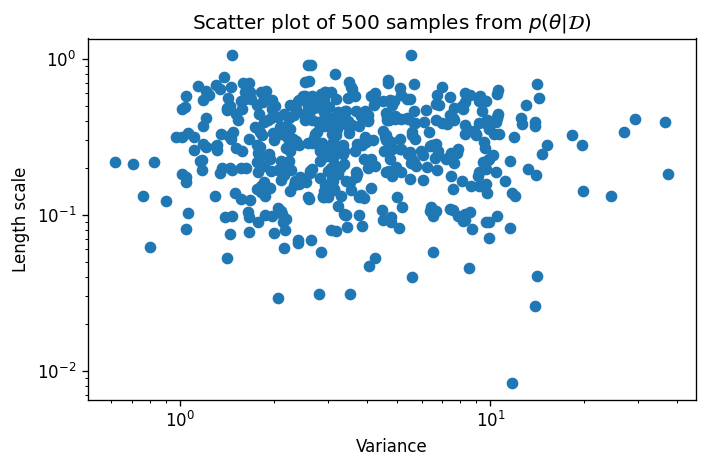

In [ ]:
# Get the samples from the posterior
name = "kernel."
posterior_vr = mcmc.get_samples(500)[name + "variance"]
posterior_ls = mcmc.get_samples(500)[name + "lengthscale"]

# Log - Log plot of the samples
fig, ax = plt.subplots(1, 1, dpi = 120)
ax.scatter(posterior_vr.detach().numpy(), posterior_ls.detach().numpy())
ax.set_xlabel("Variance")
ax.set_ylabel("Length scale")
ax.set_title("Scatter plot of 500 samples from " + r"$p\left(\theta|\mathcal{D}\right)$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
kernel = gp.kernels.RBF(input_dim = 1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(1e-4))
nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model, adapt_step_size = True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples = 400, warmup_steps = 100, num_chains = 1)
mcmc.run()

Sample: 100%|██████████| 500/500 [00:10, 46.18it/s, step size=2.85e-01, acc. prob=0.841]


In [ ]:
N = 200
i = 0
K = 10
Xt = X
yt = y
Xopt = torch.empty(0, dtype=  float)
yopt = torch.empty(0, dtype=  float)
Candidat_Set = torch.linspace(-1.0, 1.0, N)
name = "kernel."
fig, ax = plt.subplots(1, 3, dpi = 120, figsize = (15, 5) , sharey = True)
for k in range(K+1):
    # Sample the posterier
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim = 1)
    kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
    kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
    gpr = gp.models.GPRegression(Xt, yt, kernel, noise = torch.tensor(1e-4))
    nuts_kernel = pyro.infer.mcmc.NUTS(gpr.model, adapt_step_size = True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples = 150, warmup_steps = 50, num_chains = 1)
    mcmc.run()
    sample = mcmc.get_samples(1)
    all_samples = mcmc.get_samples()
    posterior_vr_bo = sample[name + "variance"]
    posterior_ls_bo = sample[name + "lengthscale"]
    posterior_vr = all_samples[name + "variance"]
    posterior_ls = all_samples[name + "lengthscale"]
    
    # Update the kernal parameters
    pyro.clear_param_store()
    kernel.lengthscale = posterior_ls_bo
    kernel.variance = posterior_vr_bo
    
    # Construct f_prime sampling function
    mean, Covar = Predictive_Posterior(Xt, Candidat_Set, yt)
    f_prime = dist.MultivariateNormal(mean, Covar).sample()
    #f_prime = dist.MultivariateNormal(mean, scale_tril=torch.tril(Covar)).sample()
    
    
    
    # Locate minimum
    #p = torch.argmin(f_prime)
    mu, variance = gpr(Candidat_Set, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    p = torch.argmin(mu - 1.5 * sigma)
    fx = f(Candidat_Set[p].unsqueeze(0))
    
    # Update dataset
    Xt = torch.cat([Xt, Candidat_Set[p].unsqueeze(0)])
    yt = torch.cat([yt, fx])
    
    # Set op optimal candidat points
    Xopt = torch.cat([Xopt, Candidat_Set[p].unsqueeze(0)])
    yopt = torch.cat([yopt, fx])
    
    if k in [0, 5, 10]:
        
        mx, vr = get_mean_and_var(posterior_ls, posterior_vr, Candidat_Set)
        std = np.diag(vr.diag().sqrt().detach().numpy())
        mx = mx.detach().numpy()
        ax[i].set_title("Iteration " + str(k))
        if k == 0:
            ax[i].set_ylabel(r"$f\left(x^*\right)$")
        ax[i].set_xlabel(r"$x^*$")
        ax[i].plot(Candidat_Set, f_prime, color = "blue", label = r"$f^*$")
        ax[i].plot(Candidat_Set, mx, color = "red", label = r"$m(x^*)$")
        ax[i].plot(Candidat_Set, f(Candidat_Set) , color = "green", label = r"$f(x)$")
        ax[i].fill_between(Candidat_Set.detach().numpy(), (mx - 2.0 * std), (mx + 2.0 * std), color = "C0", alpha = 0.3, label = r"$m(x*)\pm 2\sqrt{v\left(x*\right)}$")
        ax[i].scatter(Xopt.detach().numpy(), yopt.detach().numpy(), color = "orange", label = r"Added sample points $\left(x^*_p,\,f\left(x^*_p\right)\right)$")
        ax[i].legend()
        i += 1

plt.tight_layout()
plt.show()

Warmup:   6%|▋         | 13/200 [00:29,  3.18s/it, step size=1.31e-05, acc. prob=0.587]